In [28]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

In [29]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumnRenamed('winPlaceClass', 'label')
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('label', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDistance_SU

In [30]:
data.columns

['groupId',
 'matchId',
 'matchDuration',
 'label',
 'isFirstPerson',
 'matchtype',
 'maxPlace',
 'numGroups',
 'hasDisconnected',
 'assist_SUM',
 'assist_MAX',
 'assist_AVG',
 'heals_SUM',
 'heals_MAX',
 'heals_AVG',
 'kills_SUM',
 'kills_MAX',
 'kills_AVG',
 'headshotKills_SUM',
 'headshotKills_MAX',
 'headshotKills_AVG',
 'killStreaks_MAX',
 'roadKills_SUM',
 'roadKills_MAX',
 'roadKills_AVG',
 'longestKill_MAX',
 'vehicleDestroys_MAX',
 'weaponsAcquired_SUM',
 'weaponsAcquired_MAX',
 'weaponsAcquired_AVG',
 'damageDealt_SUM',
 'damageDealt_MAX',
 'damageDealt_AVG',
 'distance_SUM',
 'distance_MAX',
 'distance_AVG',
 'rideDistance_SUM',
 'rideDistance_MAX',
 'rideDistance_AVG',
 'swimDistance_SUM',
 'swimDistance_MAX',
 'swimDistance_AVG',
 'walkDistance_SUM',
 'walkDistance_MAX',
 'walkDistance_AVG',
 'DBNOs_SUM',
 'DBNOs_MAX',
 'DBNOs_AVG',
 'revives_SUM',
 'revives_MAX',
 'revives_AVG',
 'teamKills_SUM',
 'teamKills_MAX',
 'teamKills_AVG',
 'killPlace_MAX',
 'rankPoints_MAX',
 'k

In [31]:
inputCols =  ['matchDuration',
 'isFirstPerson',
 'matchtype',
 'maxPlace',
 'numGroups',
 'hasDisconnected',
 'assist_SUM',
 'assist_MAX',
 'assist_AVG',
 'heals_SUM',
 'heals_MAX',
 'heals_AVG',
 'kills_SUM',
 'kills_MAX',
 'kills_AVG',
 'headshotKills_SUM',
 'headshotKills_MAX',
 'headshotKills_AVG',
 'killStreaks_MAX',
 'roadKills_SUM',
 'roadKills_MAX',
 'roadKills_AVG',
 'longestKill_MAX',
 'vehicleDestroys_MAX',
 'weaponsAcquired_SUM',
 'weaponsAcquired_MAX',
 'weaponsAcquired_AVG',
 'damageDealt_SUM',
 'damageDealt_MAX',
 'damageDealt_AVG',
 'distance_SUM',
 'distance_MAX',
 'distance_AVG',
 'rideDistance_SUM',
 'rideDistance_MAX',
 'rideDistance_AVG',
 'swimDistance_SUM',
 'swimDistance_MAX',
 'swimDistance_AVG',
 'walkDistance_SUM',
 'walkDistance_MAX',
 'walkDistance_AVG',
 'DBNOs_SUM',
 'DBNOs_MAX',
 'DBNOs_AVG',
 'revives_SUM',
 'revives_MAX',
 'revives_AVG',
 'teamKills_SUM',
 'teamKills_MAX',
 'teamKills_AVG',
 'killPlace_MAX',
 'rankPoints_MAX',
 'killPoints_MAX',
 'winPoints_MAX']

toRemove = ['killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX']
inputCols = list(set(inputCols) - set(toRemove))

In [32]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [33]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.1, seed).select("features", "label")

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 141133
testing: 60299


In [10]:
training.groupBy('label').count().toPandas()

,label,count
0,1,3232
1,6,3364
2,3,32927
3,5,33613
4,4,34862
5,2,33100


## GridSearch

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 7, 12]) \ 
    .addGrid(dt.minInstancesPerNode, [5, 10, 50]) \
    .addGrid(dt.impurity, ['gini','entropy']) \
    .addGrid(dt.minInfoGain, [0.0]) \
    .build()


paramGrid = ParamGridBuilder() .addGrid(dt.maxDepth, [10, 15, 20])  \
    .addGrid(dt.minInstancesPerNode, [50, 100, 150]) \
    .addGrid(dt.impurity, ['entropy']) \
    .addGrid(dt.minInfoGain, [0.0]) \
    .build()

In [18]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", seed=42)

paramGrid = ParamGridBuilder() .addGrid(dt.maxDepth, [13, 14, 15, 16, 17, 18])  \
    .addGrid(dt.minInstancesPerNode, [50]) \
    .addGrid(dt.impurity, ['entropy']) \
    .addGrid(dt.minInfoGain, [0.0]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 

cvModel = crossval.fit(training)

In [20]:
# Best parameters
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='DecisionTreeClassifier_820fdc61a372', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 13, Param(parent='DecisionTreeClassifier_820fdc61a372', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 50, Param(parent='DecisionTreeClassifier_820fdc61a372', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy', Param(parent='DecisionTreeClassifier_820fdc61a372', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}


In [21]:
model = cvModel.bestModel

In [22]:
predictions = model.transform(testing)

In [43]:
dt = DecisionTreeClassifier(maxDepth=13, labelCol="label",
                            featuresCol="features", impurity="entropy",
                            minInstancesPerNode=50, minInfoGain=0.0,
                            seed=42)
model = dt.fit(training)

In [44]:
predictions = model.transform(testing)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|    3|[0.0,0.0,64.0,317...|[0.0,0.0,0.150234...|       3.0|
|(51,[0,1,2,3,4,5,...|    4|[0.0,0.0,1.0,189....|[0.0,0.0,7.570022...|       4.0|
|(51,[0,1,2,3,4,5,...|    3|[0.0,0.0,72.0,258...|[0.0,0.0,0.198347...|       3.0|
|(51,[0,1,2,3,4,5,...|    4|[0.0,0.0,13.0,156...|[0.0,0.0,0.055319...|       3.0|
|(51,[0,1,2,3,4,5,...|    3|[0.0,0.0,39.0,125...|[0.0,0.0,0.169565...|       3.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [23]:
features_importances = (
     pd.DataFrame(
       model.featureImportances.toArray(), 
       index=inputCols, 
       columns=['importance'])
)
features_importances.nlargest(20, columns='importance')

,importance
walkDistance_AVG,0.606093
walkDistance_MAX,0.114490
matchDuration,0.047206
maxPlace,0.041977
hasDisconnected,0.040242
numGroups,0.034633
kills_AVG,0.025437
distance_MAX,0.024136
distance_AVG,0.019131
kills_SUM,0.009647


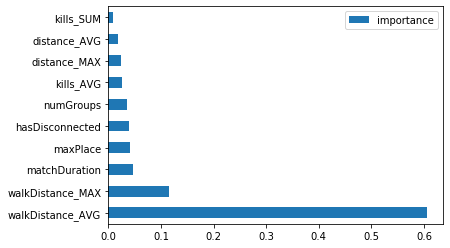

In [24]:
features_importances.nlargest(10, columns='importance').plot.barh()

In [25]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_820fdc61a372, depth=13, numNodes=1233, numClasses=7, numFeatures=51
  If (feature 37 <= 780.95)
   If (feature 37 <= 160.55)
    If (feature 1 <= 0.5)
     If (feature 37 <= 76.22999999999999)
      If (feature 45 <= 35.5)
       If (feature 37 <= 36.08)
        If (feature 31 <= 17.03)
         Predict: 6.0
        Else (feature 31 > 17.03)
         If (feature 50 <= 67.63166666666666)
          If (feature 5 <= 0.5)
           Predict: 6.0
          Else (feature 5 > 0.5)
           If (feature 45 <= 28.5)
            Predict: 6.0
           Else (feature 45 > 28.5)
            Predict: 5.0
         Else (feature 50 > 67.63166666666666)
          Predict: 5.0
       Else (feature 37 > 36.08)
        Predict: 5.0
      Else (feature 45 > 35.5)
       If (feature 31 <= 36.44166666666666)
        If (feature 45 <= 50.5)
         If (feature 12 <= 20.055)
          If (feature 16 <= 0.5)
           Predict: 5.0
          Else (f

## Evaluation

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

In [27]:
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [1.0, 2.0 ,3.0, 4.0, 5.0, 6.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7113733549905525
Precision = 0.7086791024349731
F1 measure = 0.707429214021439
Accuracy = 0.7113733549905525
Class 1.0 precision = 0.6166982922201139
Class 1.0 recall = 0.2238292011019284
Class 1.0 F1 Measure = 0.32844871147043964
Class 2.0 precision = 0.7288727663576515
Class 2.0 recall = 0.7693398567680635
Class 2.0 F1 Measure = 0.7485597985442753
Class 3.0 precision = 0.6345975287479466
Class 3.0 recall = 0.6283592644978784
Class 3.0 F1 Measure = 0.6314629899434988
Class 4.0 precision = 0.6897222594928217
Class 4.0 recall = 0.6883829929695346
Class 4.0 F1 Measure = 0.6890519754699909
Class 5.0 precision = 0.7915775401069519
Class 5.0 recall = 0.8236194185561274
Class 5.0 F1 Measure = 0.8072806598950168
Class 6.0 precision = 0.6992409867172675
Class 6.0 recall = 0.5558069381598794
Class 6.0 F1 Measure = 0.619327731092437
Confusion Matrix
[[3.2500e+02 1.0730e+03 4.3000e+01 1.0000e+00 2.0000e+00 8.0000e+00]
 [1.9500e+02 1.0850e+04 2.9450e+03 1.1100e+02 2.0000e+00 0.0000e+00]

In [57]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction")
evaluator.setMetricName('f1')
f1 = evaluator.evaluate(predictions)

#print("Test Error = %g " % (1.0 - accuracy))
print("F1 = %g " % f1)

F1 = 0.725057 


In [38]:
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions)
print("accuracy = %g " % accuracy)

accuracy = 0.735367 


In [62]:
metrics = ['f1', 'accuracy',  'weightedPrecision',  'weightedRecall',  'weightedTruePositiveRate', 
          'weightedFalsePositiveRate',  'weightedFMeasure', 'truePositiveRateByLabel',
          'falsePositiveRateByLabel', 'precisionByLabel',  'recallByLabel',  'fMeasureByLabel',  'logLoss',  'hammingLoss']

byLabel = ['truePositiveRateByLabel','falsePositiveRateByLabel', 'precisionByLabel',  'recallByLabel',  'fMeasureByLabel']
labels = [1,2,3,4,5,6]

for metric in metrics:
    print(metric)
    evaluator.setMetricName(metric)
    
    if metric in byLabel:
        for c in  labels:
            evaluator.setMetricLabel(c)
            print(F'{c} = {evaluator.evaluate(predictions)}')
    else:
        print(evaluator.evaluate(predictions))
    print('#########################################################')

f1
0.7250574298966894
#########################################################
accuracy
0.7353666666666666
#########################################################
weightedPrecision
0.7200817833760604
#########################################################
weightedRecall
0.7353666666666667
#########################################################
weightedTruePositiveRate
0.7353666666666667
#########################################################
weightedFalsePositiveRate
0.08150905942758307
#########################################################
weightedFMeasure
0.7250574298966894
#########################################################
truePositiveRateByLabel
1 = 0.0
2 = 0.8111747851002865
3 = 0.6009876543209877
4 = 0.8039978168917997
5 = 0.8195253955037469
6 = 0.5003663003663004
#########################################################
falsePositiveRateByLabel
1 = 0.0
2 = 0.10043440486533449
3 = 0.09309328968903437
4 = 0.10987605310749415
5 = 0.03832148811090638
6 = 0.0044171

KeyboardInterrupt: 

In [ ]:
# (f1 | accuracy | weightedPrecision | weightedRecall | weightedTruePositiveRate | 
#  weightedFalsePositiveRate | weightedFMeasure | truePositiveRateByLabel | 
# falsePositiveRateByLabel | precisionByLabel | recallByLabel | fMeasureByLabel | 
# logLoss | hammingLoss

## Sklearn metrics

In [108]:
from sklearn.metrics import classification_report, confusion_matrix

In [107]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [109]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.29      0.39       525
           2       0.75      0.81      0.78      5621
           3       0.69      0.67      0.68      5775
           4       0.76      0.79      0.77      5995
           5       0.88      0.85      0.86      5873
           6       0.70      0.63      0.66       588

    accuracy                           0.77     24377
   macro avg       0.73      0.67      0.69     24377
weighted avg       0.76      0.77      0.76     24377



In [110]:
print(confusion_matrix(y_true, y_pred))

[[ 152  367    6    0    0    0]
 [  94 4534  966   26    1    0]
 [  10 1138 3895  727    5    0]
 [   0   33  775 4709  478    0]
 [   3    0   11  700 4996  163]
 [   3    0    3    0  209  373]]


In [111]:
spark.stop()